# BERT i RoBERTa

In [39]:
import pandas as pd
import numpy as np

import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from transformers import RobertaModel, RobertaTokenizerFast
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import RobertaModel, RobertaTokenizerFast
from sklearn.preprocessing import LabelEncoder

import time

import warnings
warnings.filterwarnings('ignore')

In [199]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Učitavanje podataka

In [41]:
dataset_path = 'full_dataset/full_dataset.csv'
data = pd.read_csv(dataset_path)
data

,emotion,original_text,text_tokens,preprocessed_text
0,happiness,"During the period of falling in love, each tim...","['period', 'falling', 'love', 'time', 'met', '...",period falling love time met especially met lo...
1,fear,When I was involved in a traffic accident.,"['involved', 'traffic', 'accident']",involved traffic accident
2,anger,When I was driving home after several days of...,"['driving', 'home', 'several', 'day', 'hard', ...",driving home several day hard work motorist ah...
3,sadness,When I lost the person who meant the most to me.,"['lost', 'person', 'meant']",lost person meant
4,disgust,The time I knocked a deer down - the sight of ...,"['time', 'knocked', 'deer', 'sight', 'animal',...",time knocked deer sight animal injury helpless...
...,...,...,...,...
9882,shame,He gets real humiliated and has to leave .,"['get', 'real', 'humiliated', 'leave']",get real humiliated leave
9883,shame,They aimed for higher status jobs and felt hum...,"['aimed', 'higher', 'status', 'job', 'felt', '...",aimed higher status job felt humiliated unempl...
9884,shame,He cursed his lack of self-control ; he knew t...,"['cursed', 'lack', 'selfcontrol', 'knew', 'old...",cursed lack selfcontrol knew old biddy seen fe...
9885,shame,Sometimes I've thought I 'll never forget wha...,"['sometimes', 'ive', 'thought', 'never', 'forg...",sometimes ive thought never forget happened co...


In [42]:
class_names = data['emotion'].unique()
class_names

array(['happiness', 'fear', 'anger', 'sadness', 'disgust', 'shame',
       'guilt', 'surprise'], dtype=object)

In [43]:
num_classes = len(class_names)
num_classes

8

## Priprema podataka

In [113]:
X = data['preprocessed_text'] # ili staviti original_text
Y = data['emotion']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=357)

print("Training set size = ", X_train.shape[0])
print("Test set size = ", X_test.shape[0])

Training set size =  7909
Test set size =  1978


In [114]:
encoding = {
    'happiness': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'disgust': 4,
    'shame': 5,
    'guilt': 6,
    'surprise': 7
}

y_train = [encoding[x] for x in Y_train]
y_test = [encoding[x] for x in Y_test]

Podaci se moraju posebno predprocesuirati da bi se mogli koristiti u BERT-u.

In [153]:
X_train = X_train.tolist()
X_test = X_test.tolist()

In [8]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# BERT

## Treniranje

In [9]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [10]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [11]:
learning_rate = 2e-5
epochs = 5
learner.fit_onecycle(learning_rate, epochs)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
1319/1319 [==============================] - 9168s 7s/step - loss: 1.5106 - accuracy: 0.4405 - val_loss: 0.9646 - val_accuracy: 0.6648
Epoch 2/5
1319/1319 [==============================] - 8918s 7s/step - loss: 0.8342 - accuracy: 0.7163 - val_loss: 0.8485 - val_accuracy: 0.7149
Epoch 3/5
1319/1319 [==============================] - 9066s 7s/step - loss: 0.5994 - accuracy: 0.7911 - val_loss: 0.8853 - val_accuracy: 0.7321
Epoch 4/5
1319/1319 [==============================] - 9348s 7s/step - loss: 0.3002 - accuracy: 0.8996 - val_loss: 0.9889 - val_accuracy: 0.7164
Epoch 5/5
1319/1319 [==============================] - 8905s 7s/step - loss: 0.1049 - accuracy: 0.9702 - val_loss: 1.1123 - val_accuracy: 0.7240


In [23]:
class_names = np.array(class_names).tolist()
class_names

['happiness',
 'fear',
 'anger',
 'sadness',
 'disgust',
 'shame',
 'guilt',
 'surprise']

In [24]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

62/62 [==============================] - 628s 10s/step
              precision    recall  f1-score   support

   happiness       0.84      0.84      0.84       295
        fear       0.82      0.81      0.82       313
       anger       0.68      0.65      0.67       314
     sadness       0.79      0.80      0.79       334
     disgust       0.64      0.67      0.65       226
       shame       0.61      0.63      0.62       253
       guilt       0.56      0.54      0.55       205
    surprise       1.00      1.00      1.00        38

    accuracy                           0.72      1978
   macro avg       0.74      0.74      0.74      1978
weighted avg       0.72      0.72      0.72      1978



array([[247,   9,   4,  19,   5,   4,   7,   0],
       [ 10, 253,  16,   8,  12,   8,   6,   0],
       [  5,  10, 204,  15,  32,  24,  24,   0],
       [ 12,  11,   7, 267,  11,  12,  14,   0],
       [  2,   7,  29,   9, 152,  19,   8,   0],
       [ 12,   9,  17,   8,  17, 160,  30,   0],
       [  5,   8,  22,  13,  10,  36, 111,   0],
       [  0,   0,   0,   0,   0,   0,   0,  38]], dtype=int64)

## Testiranje

In [25]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['happiness',
 'fear',
 'anger',
 'sadness',
 'disgust',
 'shame',
 'guilt',
 'surprise']

In [29]:
message = 'I like apples'

start_time = time.time() 
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

predicted: happiness (0.32)


## Spremanje modela

In [19]:
predictor.save("models/bert_model")

# RoBERTa

## Priprema podataka

In [155]:
y_train_reshaped = np.array(y_train).reshape(-1, 1)
y_test_reshaped = np.array(y_test).reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)

y_train_onehot = encoder.fit_transform(y_train_reshaped)
y_test_onehot = encoder.transform(y_test_reshaped)

In [157]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

In [158]:
MAX_LEN = 128

In [159]:
class EmotionsDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_len):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [160]:
train_dataset = EmotionsDataset(X_train, y_train_onehot, tokenizer, MAX_LEN)
test_dataset = EmotionsDataset(X_test, y_test_onehot, tokenizer, MAX_LEN)

In [162]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Treniranje modela

In [ ]:
roberta_model = RobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

class EmotionClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [163]:
lr = 2e-5
num_epochs = 4

In [178]:
classifier = EmotionClassifier(roberta_model, num_classes)

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']  
        labels = batch['label']

        optimizer.zero_grad()
        outputs = classifier(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        y_true = torch.max(labels, dim=1).indices
        loss = criterion(outputs, y_true)

        loss.backward()
        optimizer.step()

        total += labels.size(0)
        train_correct += (predicted == y_true).sum().item()
        train_loss += loss.item()

    train_accuracy = train_correct / total
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f}")

Epoch 1/4: 100%|██████████| 248/248 [2:25:19<00:00, 35.16s/it]  


Epoch 1/4 | Loss: 1.2071 | Accuracy: 0.5921


Epoch 2/4: 100%|██████████| 248/248 [2:09:01<00:00, 31.22s/it]


Epoch 2/4 | Loss: 0.7853 | Accuracy: 0.7297


Epoch 3/4: 100%|██████████| 248/248 [2:35:02<00:00, 37.51s/it]  


Epoch 3/4 | Loss: 0.5974 | Accuracy: 0.7986


Epoch 4/4: 100%|██████████| 248/248 [2:41:18<00:00, 39.03s/it]  

Epoch 4/4 | Loss: 0.4538 | Accuracy: 0.8511


## Spremanje modela

In [181]:
# spremiti classifier
torch.save(classifier.state_dict(), 'models/RoBERTa.pth')

## Testiranje

In [192]:
classifier.eval()

test_loss = 0.0
test_correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, dynamic_ncols=True):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = classifier(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        y_true = torch.max(labels, dim=1).indices
        loss = criterion(outputs, y_true)

        total += labels.size(0)
        test_correct += (predicted == y_true).sum().item()
        test_loss += loss.item()

        predictions.extend(predicted.tolist())
        true_labels.extend(y_true.tolist())
    
    test_accuracy = test_correct / total
    test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')

100%|██████████| 62/62 [15:54<00:00, 15.39s/it]

Test Loss: 0.8769 | Test Accuracy: 0.7331


In [200]:
print("Classification report:\n", classification_report(true_labels, predictions, target_names=class_names))

Classification report:
               precision    recall  f1-score   support

   happiness       0.84      0.83      0.84       295
        fear       0.80      0.81      0.81       313
       anger       0.76      0.62      0.69       314
     sadness       0.80      0.81      0.81       334
     disgust       0.69      0.74      0.71       226
       shame       0.61      0.63      0.62       253
       guilt       0.52      0.58      0.55       205
    surprise       0.90      1.00      0.95        38

    accuracy                           0.73      1978
   macro avg       0.74      0.75      0.75      1978
weighted avg       0.74      0.73      0.73      1978



<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

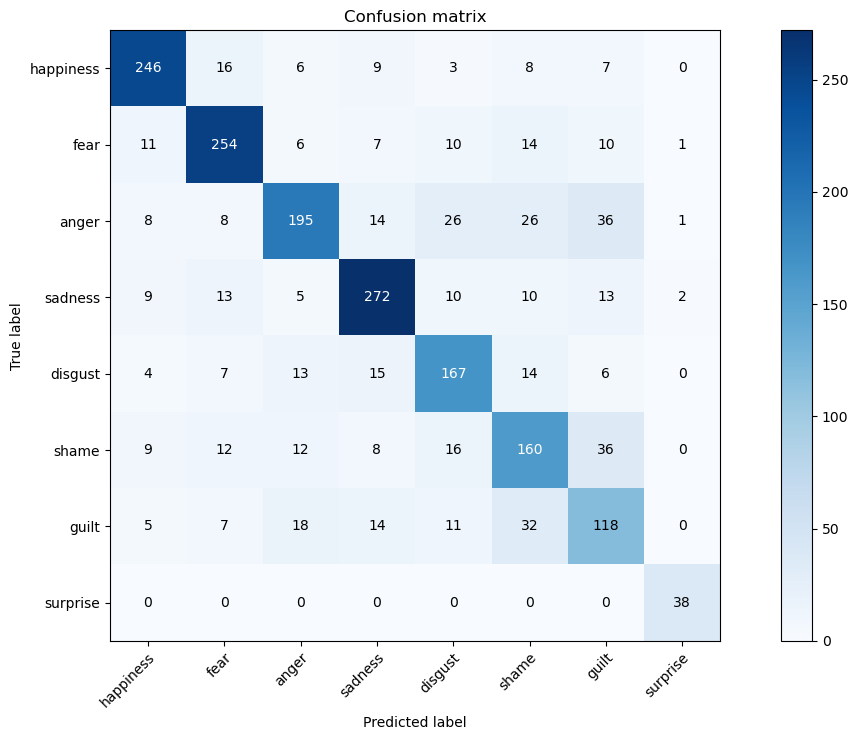

In [202]:
plot_confusion_matrix(true_labels, predictions, class_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
